# NucleaSeq Tabulation and Normalization Factors

The purpose of this notebook is in the title: tabulating the data and finding normalization factors for cleavage rate data. This is performed in a notebook so that some sanity check figures can be produced inline. And it is separate from the analysis notebook so the analysis can be performed on the condensed data alone, using much less memory.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl

In [3]:
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [4]:
import sys
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, Image

In [5]:
from nucleaseq import processing, seqtools
from nucleaseq.OligosContainer import OligosContainer

In [6]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Run Parameters

Here you should enter the parameters for the run. This should be the only section requiring user input. The parameters are as follows:

- `run_label`: The label used for the current run. This will need to be consistent across notebooks.
- `tname`: The target name. This must match the target name in the `targets.yml` file. (Example in the resources folder)
- `read_name_by_sample_fpath`: The (relative) path to the `[out_prefix]_read_names_by_sample.txt` file created during `nucleaseq setup_run`.
- `exploded_oligos_fpath`: The file with the exploded library created during library design.
- `targets_fpath`: The path to `targets.yml`.
- `pamtarg_pos`: The pam-target boundary position. Must match that used in `nucleaseq preprocess`.
- `sample_names`: The sample names, which are the directory names created for `nucleaseq setup_run`. These must be given in order: first the control sample, then the time point samples in chronological order.

In [7]:
run_label = 'Cas9_D'
tname = 'D'
read_name_by_sample_fpath = 'JA18412-100827729/Cas9_D_read_names_by_sample.txt'
exploded_oligos_fpath = 'exploded_target_d_seqs.txt'
targets_fpath = '/mnt/marble/hdd2/hawkjo/alignment_tmp/master_style/targets.yml'
pamtarg_pos = 24

In [8]:
sample_names = [
    'ControlDWE',
    'WTD0',
    'WTD12s',
    'WTD1',
    'WTD3',
    'WTD10',
    'WTD30',
    'WTD100',
    'WTD300',
    'WTD1000',
]

# Load Expected Sequences

In [9]:
targets = yaml.load(open(targets_fpath))
perfect_target = targets[tname]
print 'Target {}:'.format(tname), perfect_target

Target D: TTTAGTGATAAGTGGAATGCCATGTGG


In [10]:
oligo_container = OligosContainer(exploded_oligos_fpath, perfect_target, pamtarg_pos)

2020-04-12 05:53:16   Loaded 8,684 oligos (8,684 unique)
2020-04-12 05:53:16   Oligo lengths: Counter({116: 8684})
2020-04-12 05:53:16   43 Perfect target oligos
2020-04-12 05:53:16   8,629 Target oligos
2020-04-12 05:53:16   55 Non-target oligos
2020-04-12 05:53:16   Left/Right Primer Seqs: AACCGCCGAATAACAGAGT / AAGAACGCCTCGCACACT
2020-04-12 05:53:16   Left/Right Primer Edit Distance: 10
2020-04-12 05:53:16   Target oligo left buffers: Counter({'CAGAT': 8618, 'CAGTT': 1, 'CAGCT': 1, 'CAGTC': 1, 'CAGAA': 1, 'CAGAC': 1, 'CAGAG': 1, 'CAGTG': 1, 'CAGTA': 1, 'CAGGA': 1, 'CAGCA': 1, 'CAGGT': 1})
2020-04-12 05:53:16   Target oligo right buffers: Counter({'TGATC': 8617, 'AAGAC': 1, 'GTGAC': 1, 'AGGAC': 1, 'TCGAC': 1, 'TTGAC': 1, 'TGGAC': 1, 'CAGAC': 1, 'ATGAC': 1, 'TAGAC': 1, 'GAGAC': 1, 'ACGAC': 1, 'CTGAC': 1})
2020-04-12 05:53:16   Most common left/right buffers: CAGAT / TGATC
2020-04-12 05:53:16   31 Perfect target and most common buffer oligos
2020-04-12 05:53:16   12 Alternate buffer oli

# Load data

Missing data files in this section are normal, and give a rough check on data quality: they simply mean that one of the kinds of data didn't happen to appear in one of the raw data chunks. A few is normal. Many missing files indicates a problem, or at least an unusual processing configuration.

In [11]:
import pandas as pd
import re

In [12]:
full_data = processing.load_and_concat_dfs('{}_full_data_files'.format(run_label), 'full_data')
none_data = processing.load_and_concat_dfs('{}_none_data_files'.format(run_label), 'none_data')
wrong_data = processing.load_and_concat_dfs('{}_wrong_data_files'.format(run_label), 'wrong_data')

2020-04-12 05:53:18   full_data: 0-10,199,999  (96 files)
2020-04-12 05:53:18   Missing file between full_data.08900000-08999999.pkl full_data.09300000-09399999.pkl (300,000 missing)
2020-04-12 05:53:18   Missing file between full_data.09500000-09599999.pkl full_data.09900000-09999999.pkl (300,000 missing)
2020-04-12 05:53:18   Total missing: 600,000
2020-04-12 05:54:53   none_data: 0-10,199,999  (96 files)
2020-04-12 05:54:53   Missing file between none_data.08900000-08999999.pkl none_data.09300000-09399999.pkl (300,000 missing)
2020-04-12 05:54:53   Missing file between none_data.09500000-09599999.pkl none_data.09900000-09999999.pkl (300,000 missing)
2020-04-12 05:54:53   Total missing: 600,000
2020-04-12 05:55:12   wrong_data: 0-10,199,999  (96 files)
2020-04-12 05:55:12   Missing file between wrong_data.08900000-08999999.pkl wrong_data.09300000-09399999.pkl (300,000 missing)
2020-04-12 05:55:12   Missing file between wrong_data.09500000-09599999.pkl wrong_data.09900000-09999999.pkl

In [13]:
len(full_data), len(none_data), len(wrong_data)

(19590594, 1613940, 444148)

Pandas data frames:

| Data Frame | Description | 
| :--------: | :---------- |
| full_data | Good primers and matching barcodes |
| none_data | Good primers and one None barcode |
| wrong_data | Good primers and **mis**matching barcodes |
| left_data | Left primer and barcode but no right primer |
| right_data | Right primer and barcode but no left primer |

Additionally, a few scalars:

| Scalar | Description |
|:-----: | :---------- |
| both_none_seqs | Good primers, no barcodes, # seqs |
| both_none_reads | Good primers, no barcodes, # reads |
| left_none_seqs | Left primer only, no barcodes, # seqs |
| left_none_reads | Left primer only, no barcodes, # reads |
| right_none_seqs | Right primer only, no barcodes, # seqs |
| right_none_reads | Right primer only, no barcodes, # reads |
| no_primers_seqs | No primers, # seqs |
| no_primers_reads | No primers, # reads |

### full_data schema

| read_name | sample_name | oriented_seq | seq_len | oligo | total_edits | pieces_edits ... | pieces_boundaries ... | 
| - | - | - | - | - | - | - | - |

### none_data schema

| read_name | sample_name | oriented_seq | seq_len | missing_side | oligo | total_edits | pieces_edits ... | pieces_boundaries ... | 
| - | - | - | - | - | - | - | - | - | - |

### wrong_data schema

| read_name | sample_name | oriented_seq | seq_len | left_oligo | left_total_edits | left_pieces_edits ... | left_pieces_boundaries ... | same for right side ... |
| - | - | - | - | - | - | - | - | - | - |


### scalars

| Scalar | Description |
|:-----: | :---------- |
| both_none_seqs | Good primers, no barcodes, # seqs |
| both_none_reads | Good primers, no barcodes, # reads |


### left_right_stats

| Scalar | Description |
|:-----: | :---------- |
| left_none_seqs | Left primer only, no barcodes, # seqs |
| left_none_reads | Left primer only, no barcodes, # reads |
| right_none_seqs | Right primer only, no barcodes, # seqs |
| right_none_reads | Right primer only, no barcodes, # reads |
| no_primers_seqs | No primers, # seqs |
| no_primers_reads | No primers, # reads |
| two_lefts_seqs | Two left primers, # seqs |
| two_lefts_reads | Two left primers, # reads | 
| two_rights_seqs | Two right primers, # seqs |
| two_rights_reads | Two right primers, # reads |

### left_data and right_data schema

| read_name | sample_name | oriented_seq | seq_len | oligo | side | ref_rel_cut_pos | total_edits | pieces_edits ... | pieces_boundaries ... |
| - | - | - | - | - | - | - | - |

Where ref_rel_cut_pos is the position in the pam-defined coordinate system.

In [14]:
full_data.describe()

,seq_len,total_edits,edits_primer_left,edits_barcode_left,edits_buffer_left,edits_target,edits_buffer_right,edits_right_buffer_buffer,edits_barcode_right,edits_primer_right,start_barcode_left,start_buffer_left,start_target,start_buffer_right,start_right_buffer_buffer,start_barcode_right,start_primer_right
count,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07,1.959059e+07
mean,1.146405e+02,1.890927e+00,7.362498e-02,1.860837e-01,1.063888e-01,8.509604e-01,1.486908e-01,1.853280e-01,2.490941e-01,9.075641e-02,1.898820e+01,3.590594e+01,4.077822e+01,6.812705e+01,7.296754e+01,7.984463e+01,9.668456e+01
std,5.143965e+00,5.177497e+00,2.922605e-01,5.252859e-01,5.260968e-01,3.579963e+00,6.702336e-01,7.528633e-01,5.582193e-01,3.393455e-01,1.438617e-01,4.617152e-01,9.368598e-01,4.354945e+00,4.710421e+00,5.007097e+00,5.136877e+00
min,5.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,9.000000e+00,1.000000e+01,2.100000e+01,2.100000e+01,2.300000e+01,3.600000e+01
25%,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,3.600000e+01,4.100000e+01,6.800000e+01,7.300000e+01,8.000000e+01,9.700000e+01
50%,1.160000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,3.600000e+01,4.100000e+01,6.800000e+01,7.300000e+01,8.100000e+01,9.800000e+01
75%,1.160000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,3.600000e+01,4.100000e+01,7.000000e+01,7.500000e+01,8.100000e+01,9.800000e+01
max,1.520000e+02,6.200000e+01,3.600000e+01,3.700000e+01,1.600000e+01,4.500000e+01,3.600000e+01,3.600000e+01,3.400000e+01,1.500000e+01,5.500000e+01,7.300000e+01,7.800000e+01,1.060000e+02,1.110000e+02,1.190000e+02,1.360000e+02


In [15]:
full_data.columns

Index([u'read_name', u'sample', u'oriented_seq', u'seq_len', u'oligo',
       u'total_edits', u'edits_primer_left', u'edits_barcode_left',
       u'edits_buffer_left', u'edits_target', u'edits_buffer_right',
       u'edits_right_buffer_buffer', u'edits_barcode_right',
       u'edits_primer_right', u'start_barcode_left', u'start_buffer_left',
       u'start_target', u'start_buffer_right', u'start_right_buffer_buffer',
       u'start_barcode_right', u'start_primer_right', u'aligned_primer_left',
       u'aligned_barcode_left', u'aligned_buffer_left', u'aligned_target',
       u'aligned_buffer_right', u'aligned_right_buffer_buffer',
       u'aligned_barcode_right', u'aligned_primer_right'],
      dtype='object')

### Select good-length data

We here select data where the oligo is within 5 bp of the intended length. This can be adjusted if desired in the cell below.

In [16]:
oligo = oligo_container.target_oligos[0]
target_oligo_len = len(oligo)
min_good_len = len(oligo) - 5
max_good_len = len(oligo) + 5

In [17]:
good_len_data = full_data[full_data.seq_len <= max_good_len]
good_len_data = good_len_data[good_len_data.seq_len >= min_good_len]

In [18]:
good_len_none_data = none_data[none_data.seq_len <= max_good_len]
good_len_none_data = good_len_none_data[good_len_none_data.seq_len >= min_good_len]

good_len_wrong_data = wrong_data[wrong_data.seq_len <= max_good_len]
good_len_wrong_data = good_len_wrong_data[good_len_wrong_data.seq_len >= min_good_len]

In [19]:
good_len_left_none_data = good_len_none_data[good_len_none_data.missing_side == 'left']
good_len_right_none_data = good_len_none_data[good_len_none_data.missing_side == 'right']

good_len_left_wrong_data = good_len_wrong_data[good_len_wrong_data.left_total_edits >= good_len_wrong_data.right_total_edits]
good_len_right_wrong_data = good_len_wrong_data[good_len_wrong_data.left_total_edits < good_len_wrong_data.right_total_edits]

## Data overview figures

Below are a large number of figures looking at distributions of values found in various subsets of the data for sanity check purposes. These will hopefully not be too interesting, but can be useful for troubleshooting. Each distribution is given with both linear- (left) and log-scaled (right) y-axes. 

The data subsets are:

- Full data: All full-length data with proper primers and barcodes found on each side.
- Good length full data: Full data with acceptable sequence length, as determined in the previous section.
- None data: Data where both primers were found but one or both of the barcodes could not be identified.
- Wrong data: Data where both primers were found but the barcodes did not match.

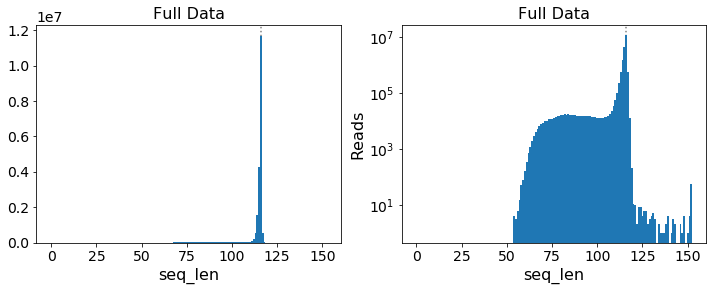

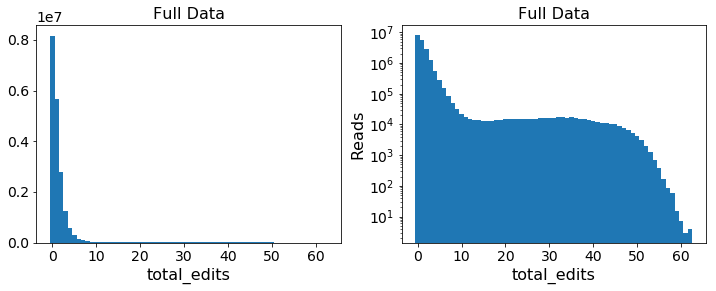

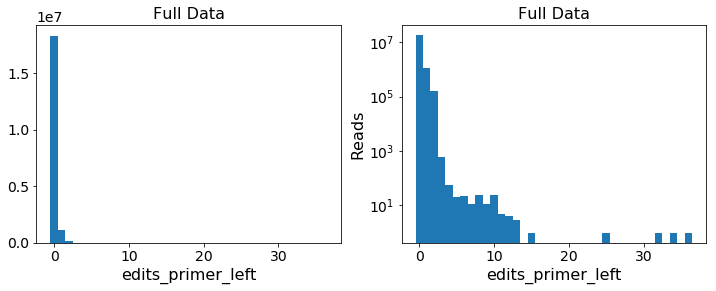

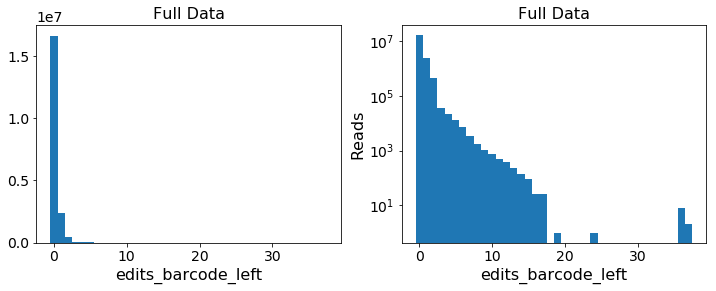

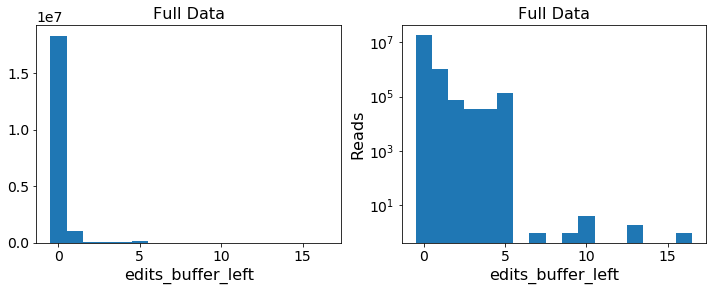

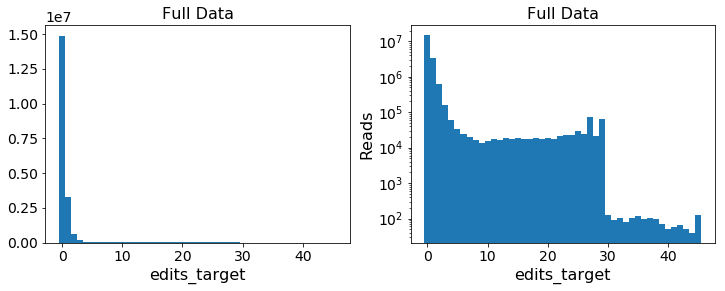

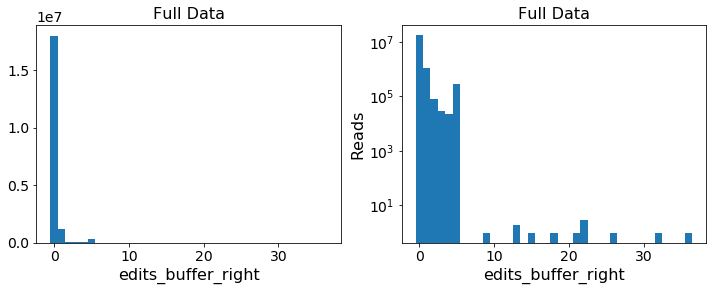

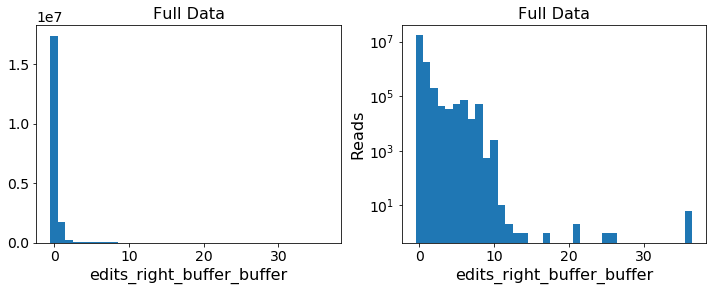

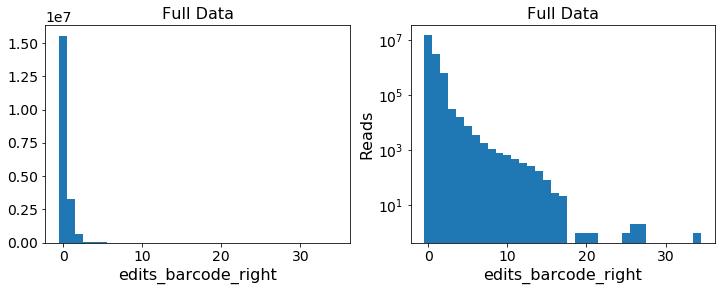

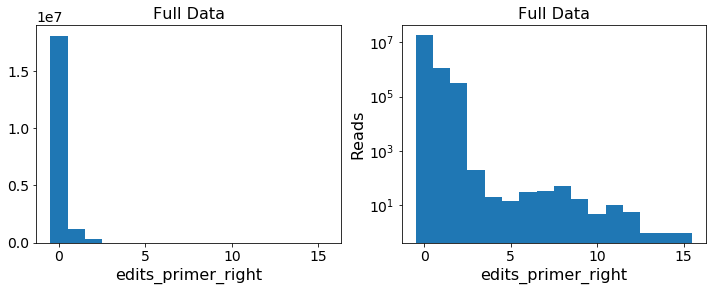

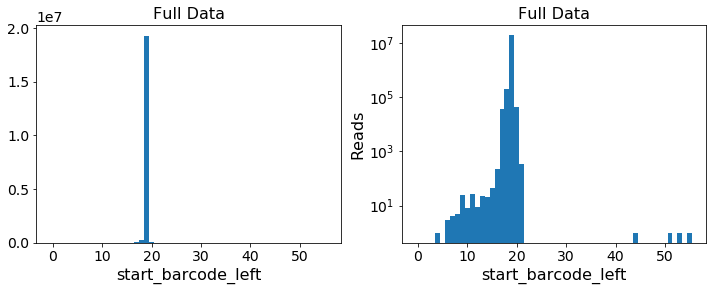

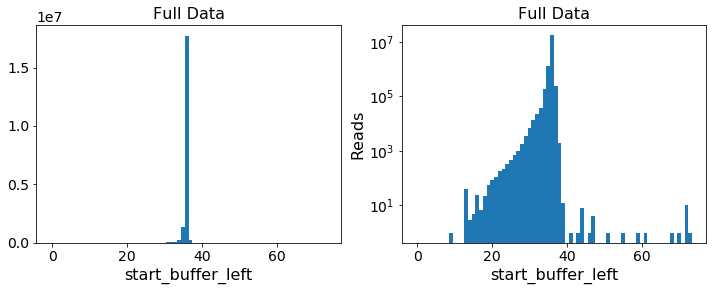

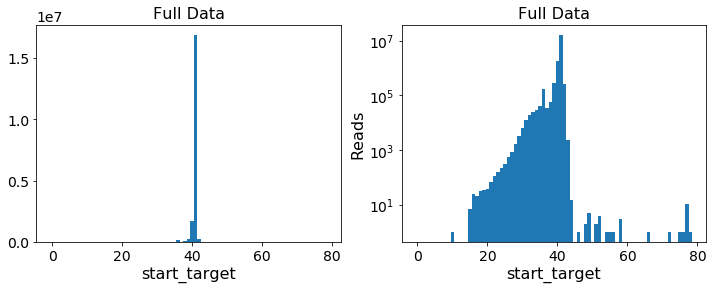

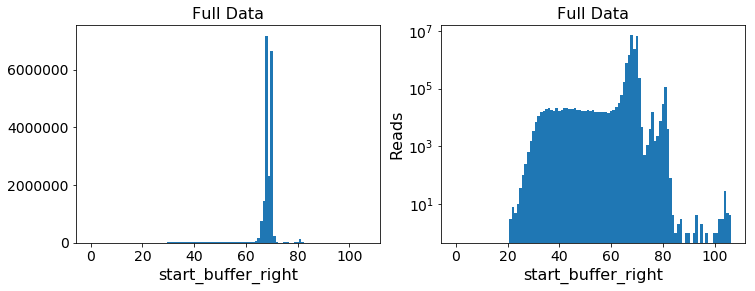

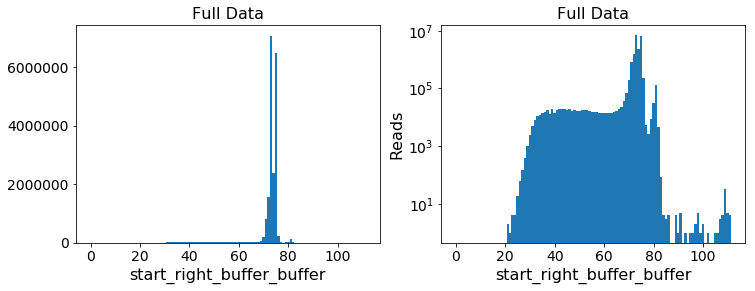

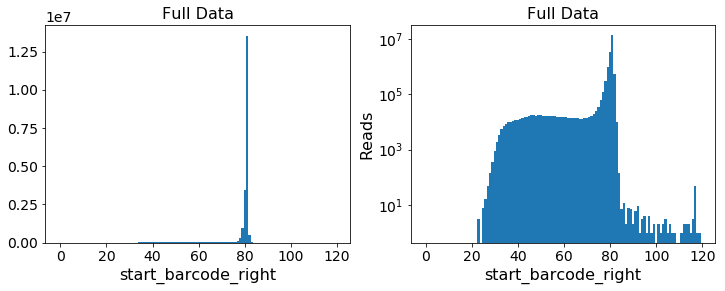

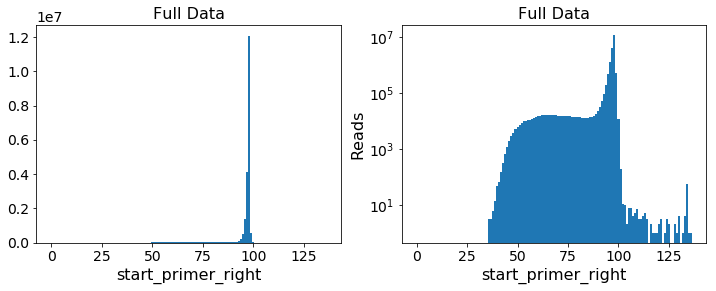

In [20]:
title = 'Full Data'
df = full_data
for label in df.columns:
    if label in ['read_name', 'sample', 'oriented_seq', 'oligo'] or 'aligned' in label:
        continue
    bins = np.arange(max(df[label]) + 2) - 0.5
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax = axes[0]
    ax.hist(df[label], bins)
    ax.set_xlabel(label)
    ax.set_title(title)
    ax = axes[1]
    ax.hist(df[label], bins)
    ax.set_yscale('log')
    ax.set_xlabel(label)
    ax.set_ylabel('Reads')
    ax.set_title(title)
    if label == 'seq_len':
        for ax in axes:
            ylim = ax.get_ylim()
            ax.plot([target_oligo_len]*2, ylim, ':', color='grey', zorder=-1)
            ax.set_ylim(ylim)

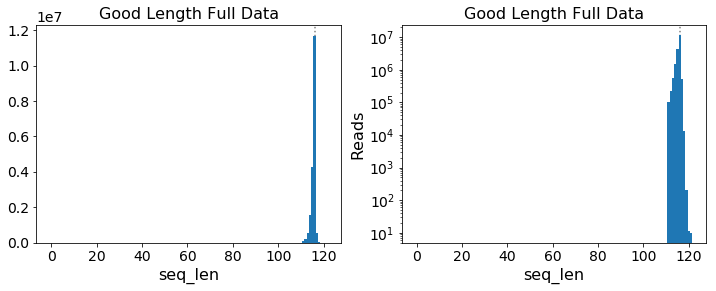

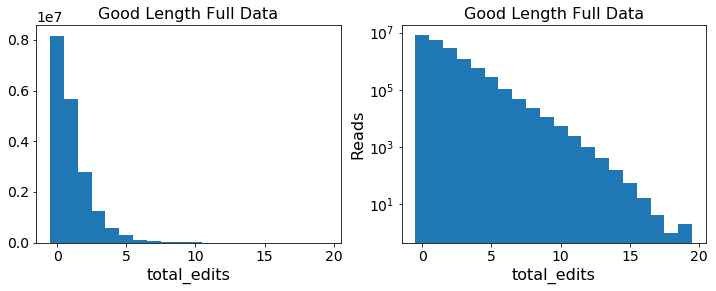

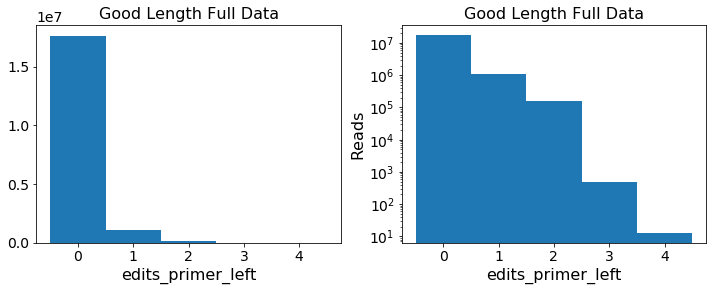

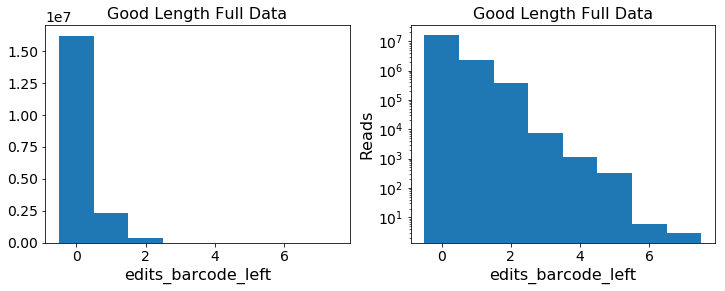

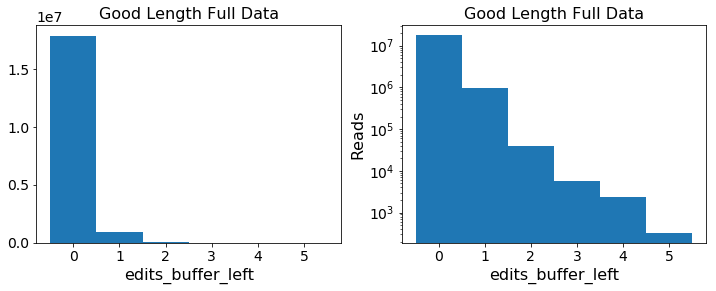

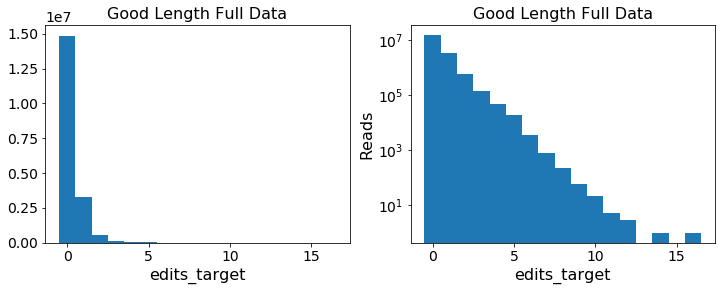

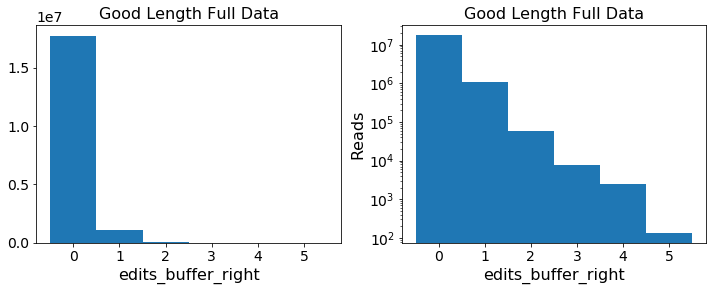

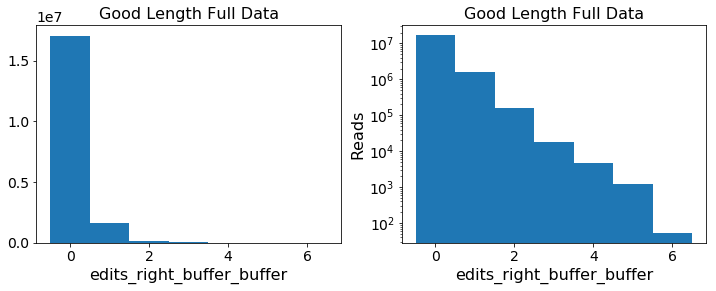

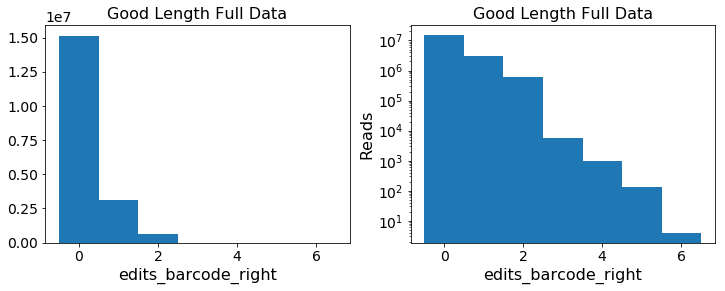

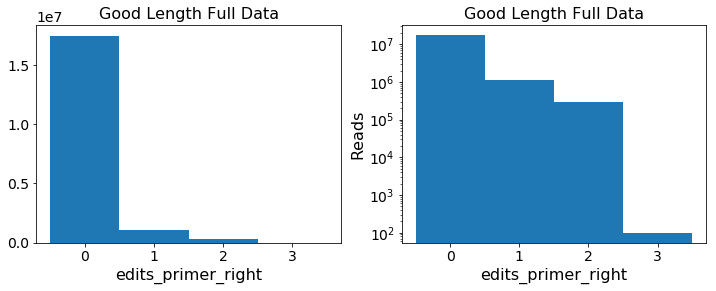

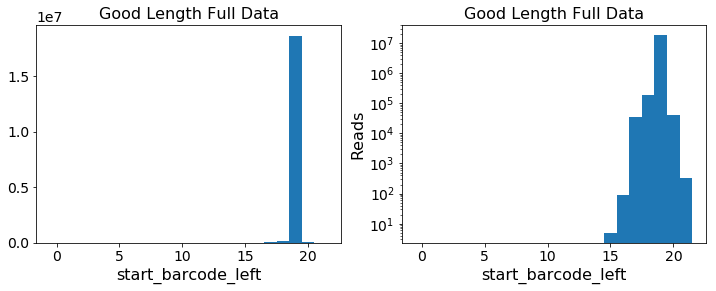

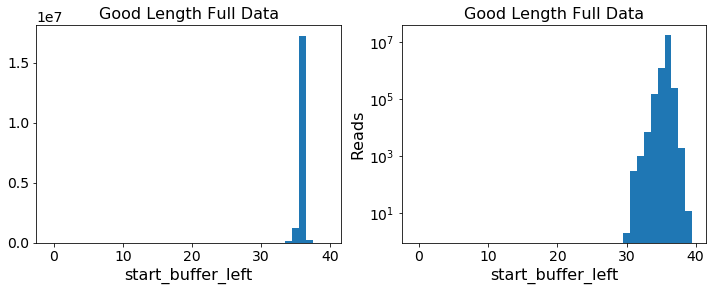

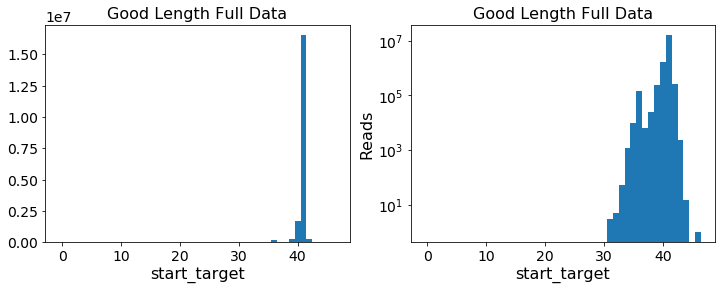

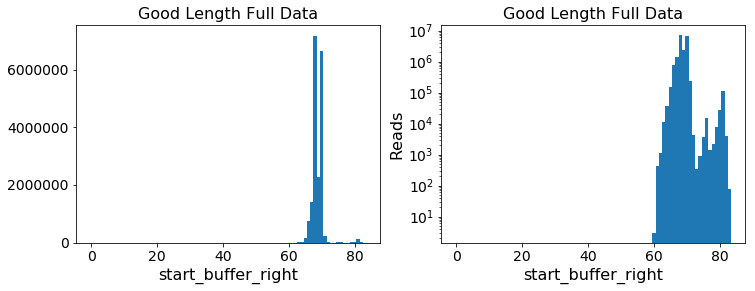

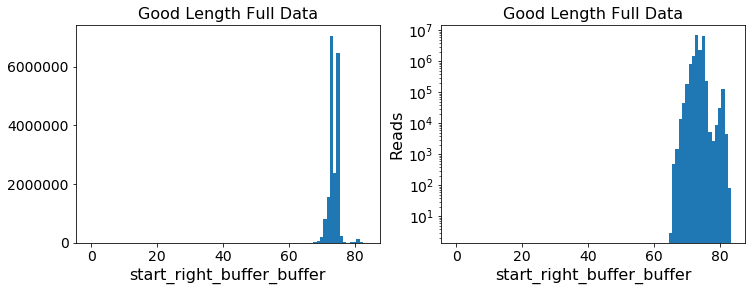

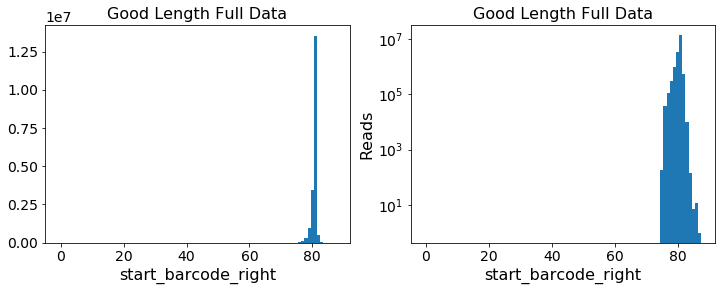

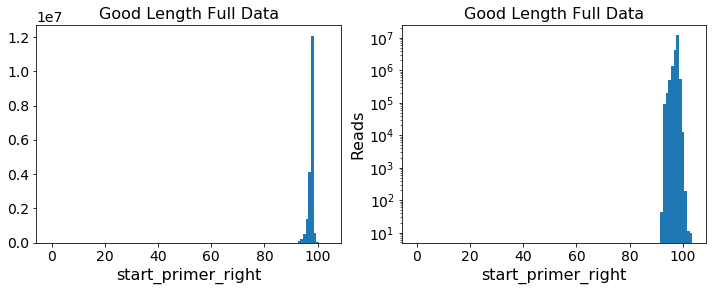

In [21]:
title = 'Good Length Full Data'
df = good_len_data
for label in df.columns:
    if label in ['read_name', 'sample', 'oriented_seq', 'oligo'] or 'aligned' in label:
        continue
    bins = np.arange(max(df[label]) + 2) - 0.5
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax = axes[0]
    ax.hist(df[label], bins)
    ax.set_xlabel(label)
    ax.set_title(title)
    ax = axes[1]
    ax.hist(df[label], bins)
    ax.set_yscale('log')
    ax.set_xlabel(label)
    ax.set_ylabel('Reads')
    ax.set_title(title)
    if label == 'seq_len':
        for ax in axes:
            ylim = ax.get_ylim()
            ax.plot([target_oligo_len]*2, ylim, ':', color='grey', zorder=-1)
            ax.set_ylim(ylim)

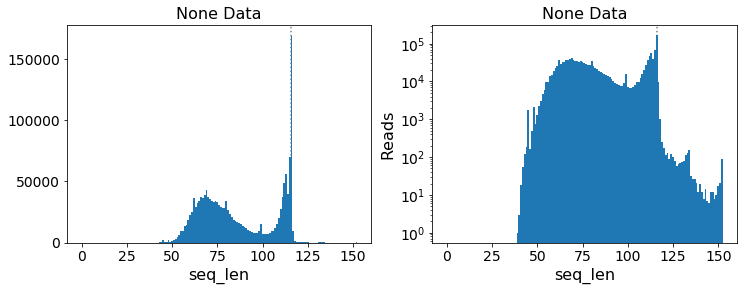

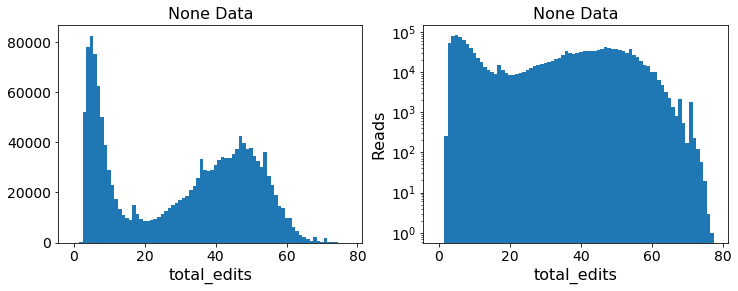

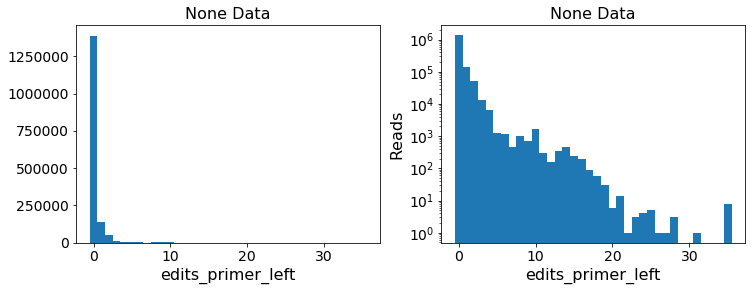

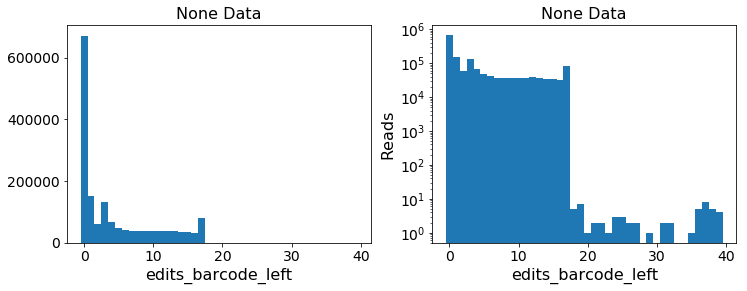

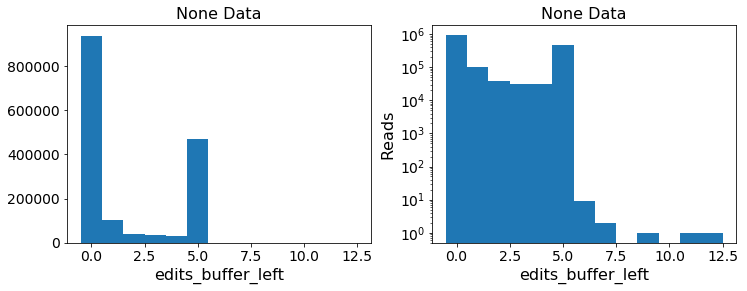

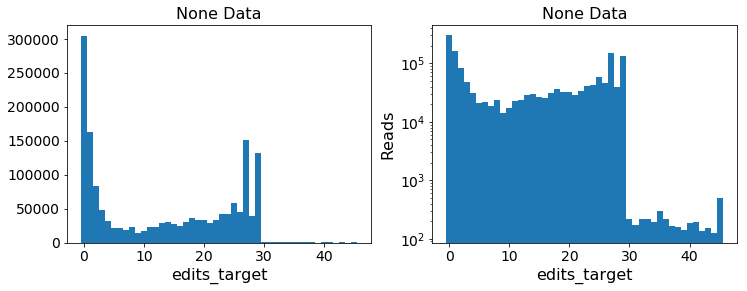

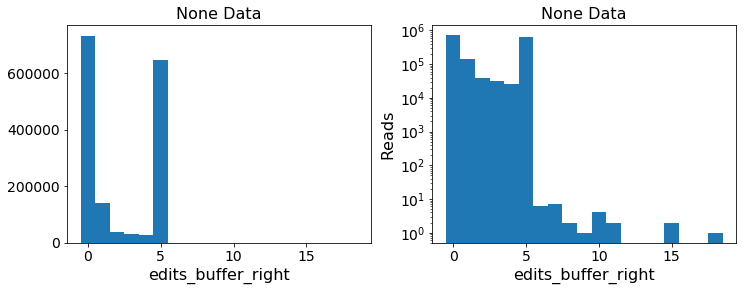

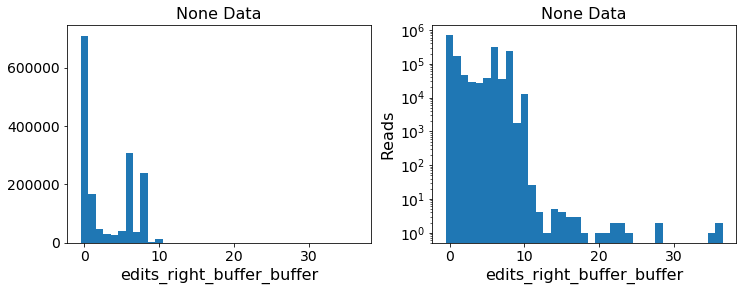

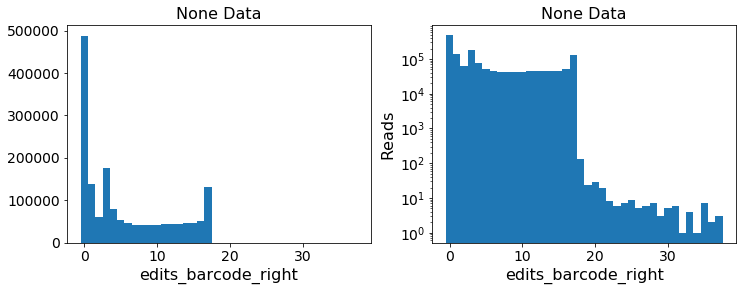

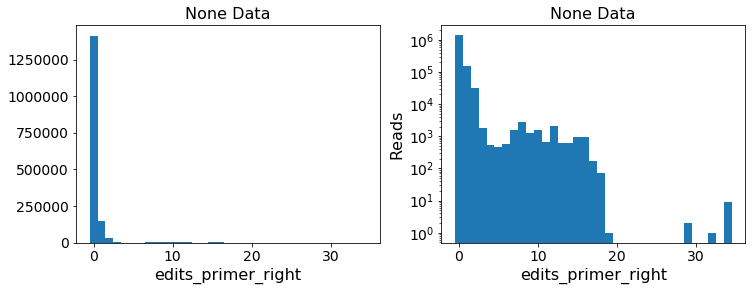

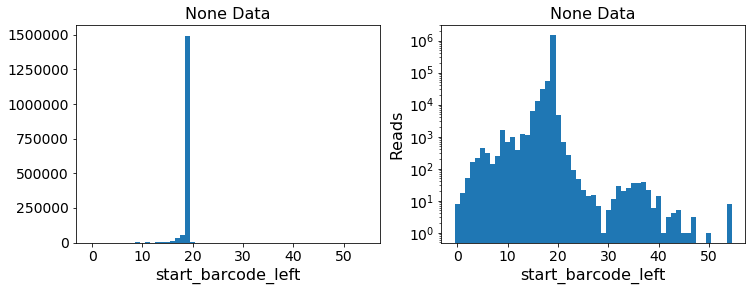

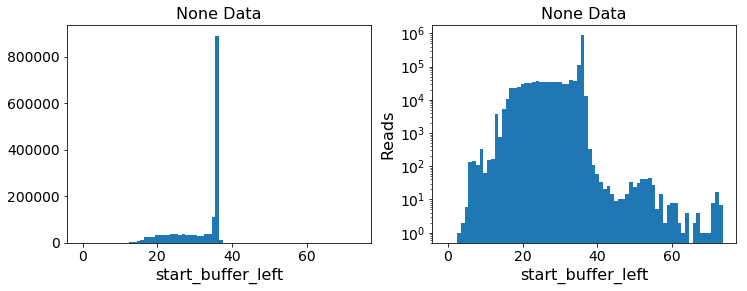

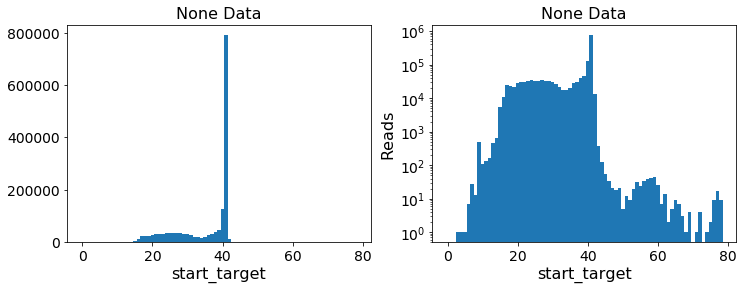

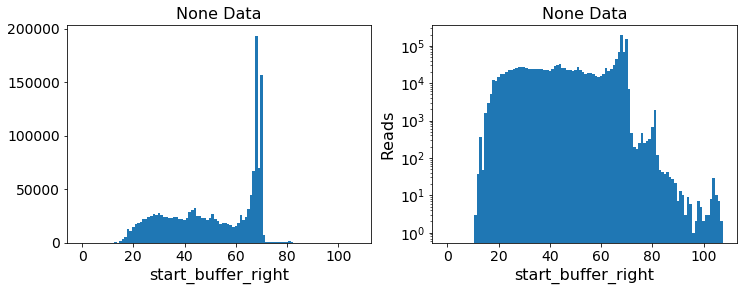

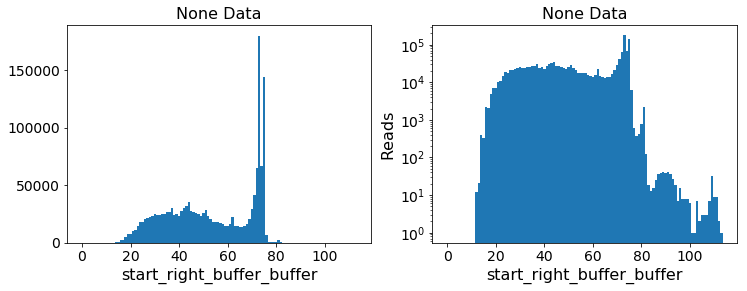

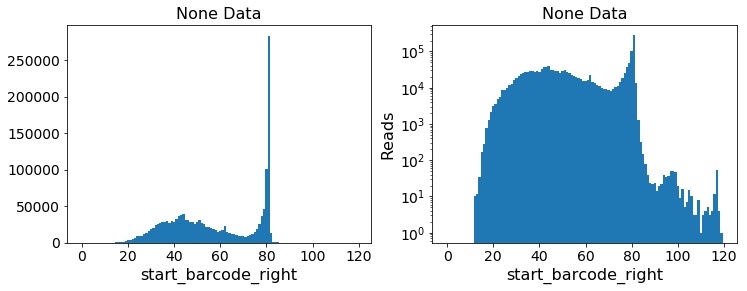

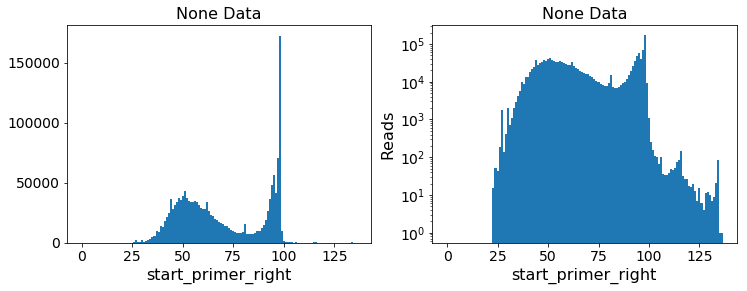

In [22]:
title = 'None Data'
df = none_data
for label in df.columns:
    if label in ['read_name', 'sample', 'oriented_seq', 'oligo', 'missing_side'] or 'aligned' in label:
        continue
    bins = np.arange(max(df[label]) + 2) - 0.5
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax = axes[0]
    ax.hist(df[label], bins)
    ax.set_xlabel(label)
    ax.set_title(title)
    ax = axes[1]
    ax.hist(df[label], bins)
    ax.set_yscale('log')
    ax.set_xlabel(label)
    ax.set_ylabel('Reads')
    ax.set_title(title)
    if label == 'seq_len':
        for ax in axes:
            ylim = ax.get_ylim()
            ax.plot([target_oligo_len]*2, ylim, ':', color='grey', zorder=-1)
            ax.set_ylim(ylim)

/mnt/marble/hdd2/hawkjo/barcode_and_nucleaseq/src/nucleaseq/envnucleaseq/local/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


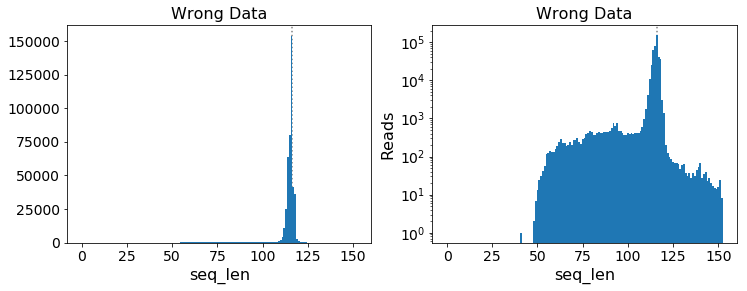

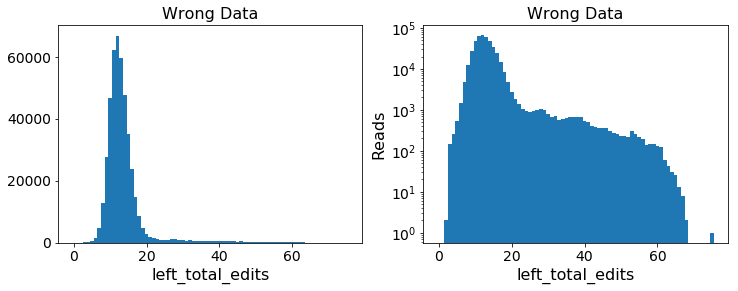

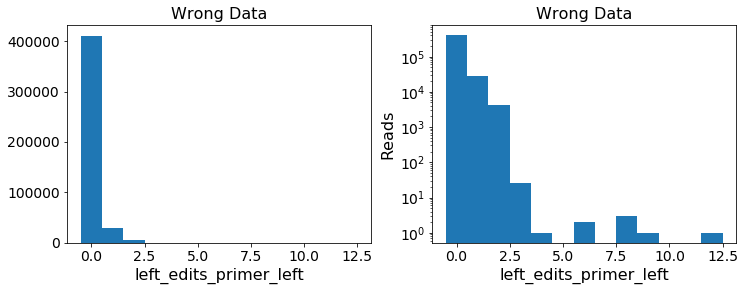

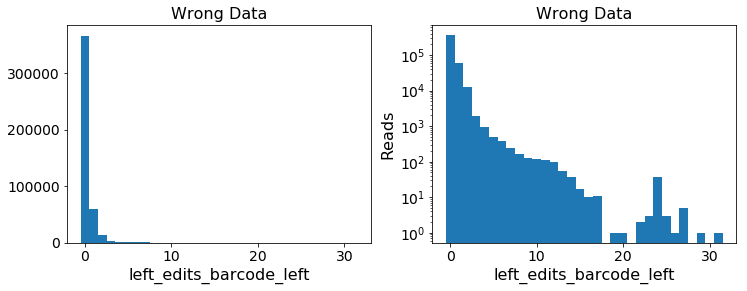

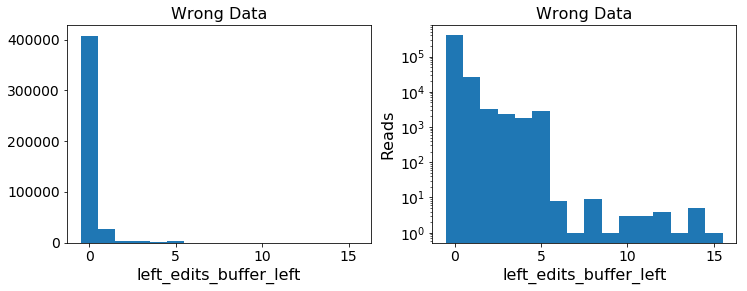

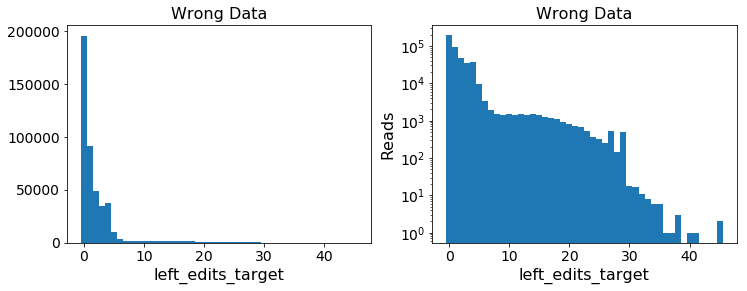

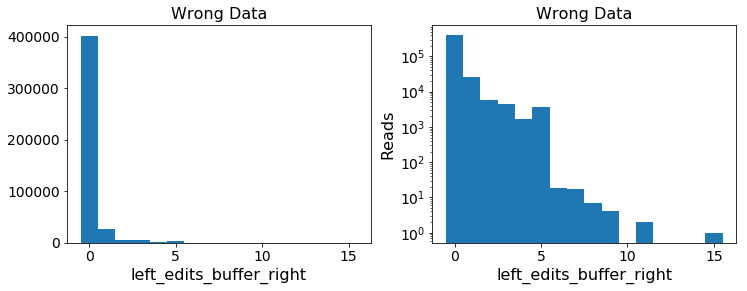

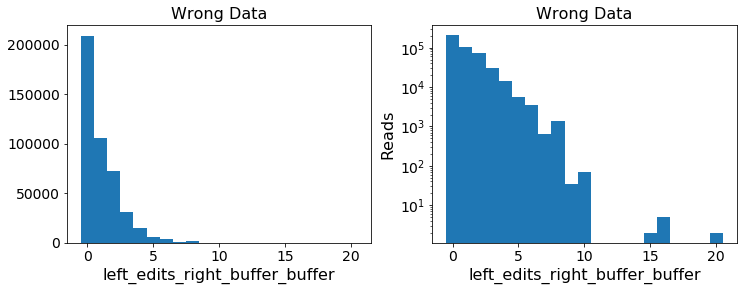

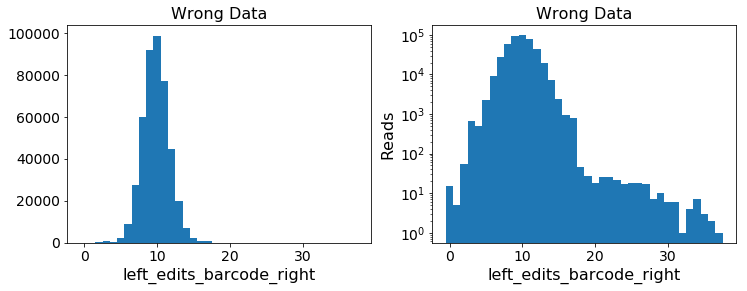

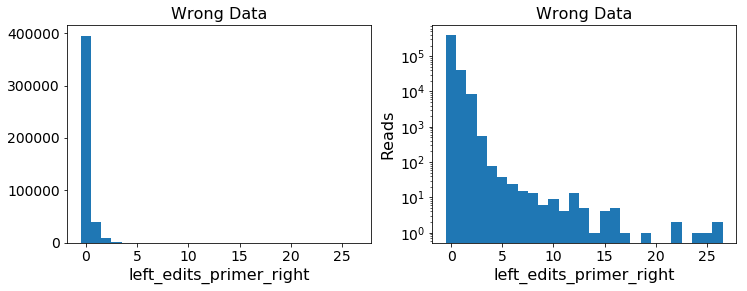

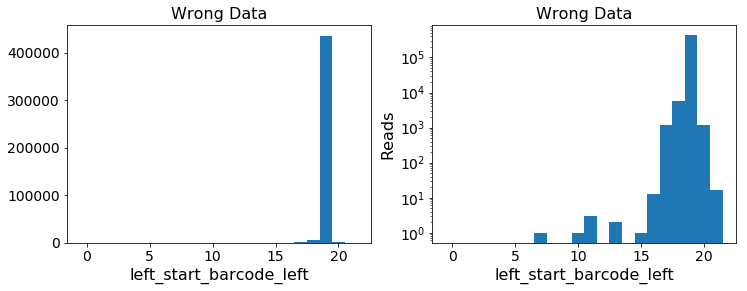

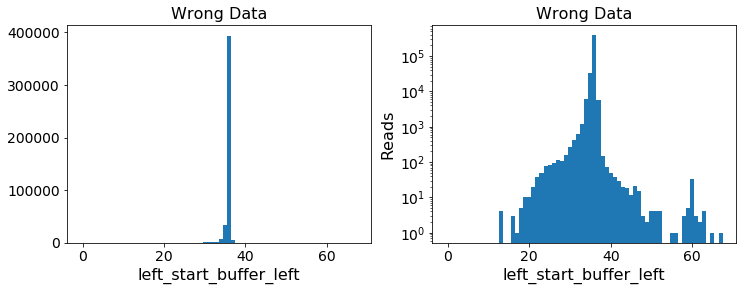

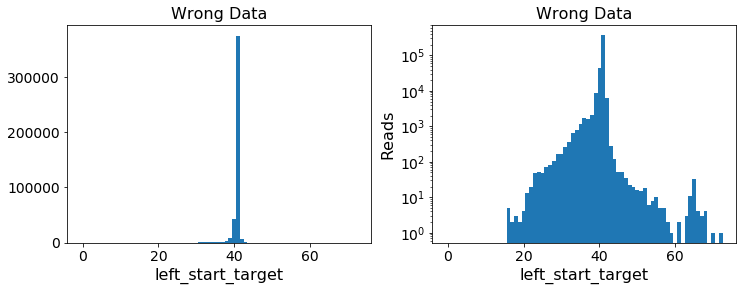

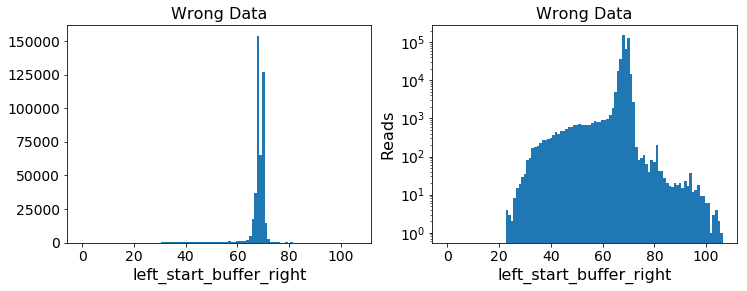

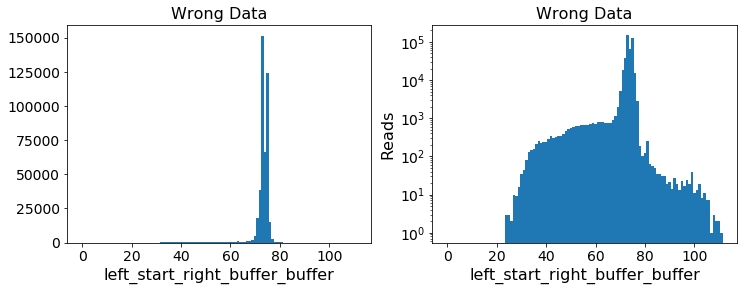

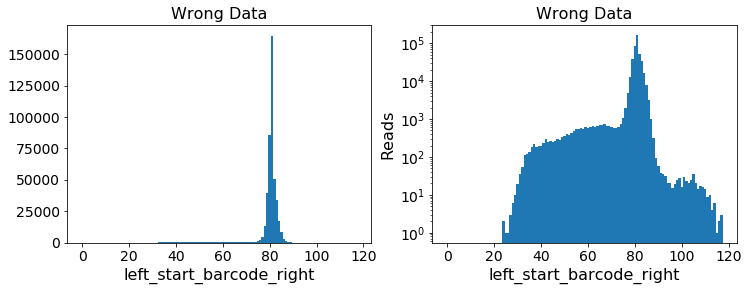

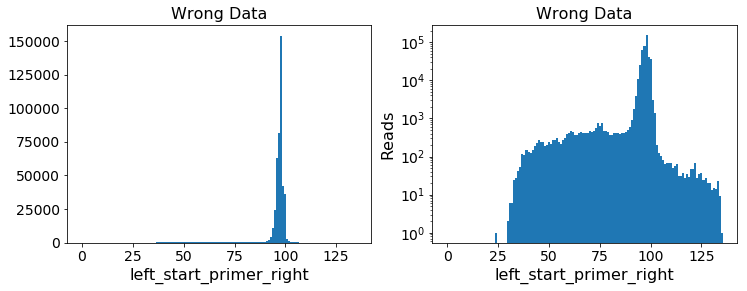

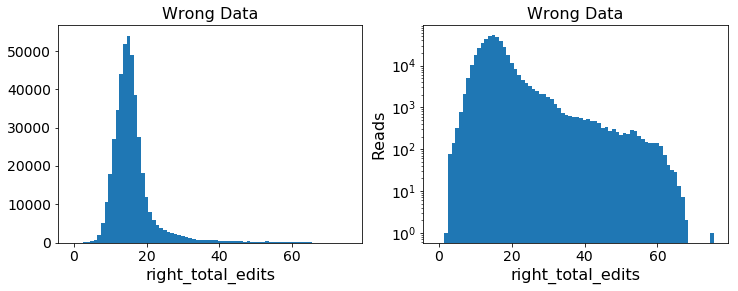

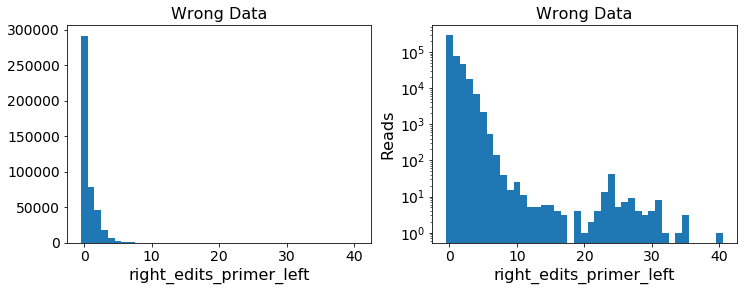

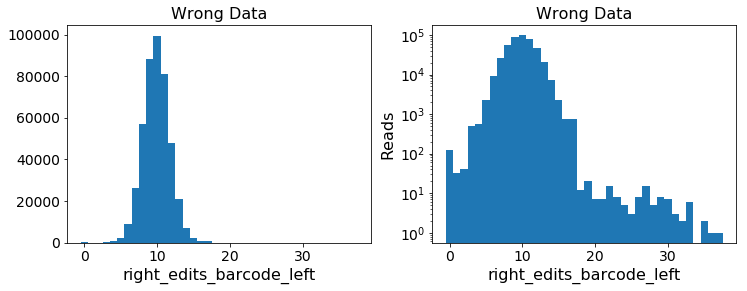

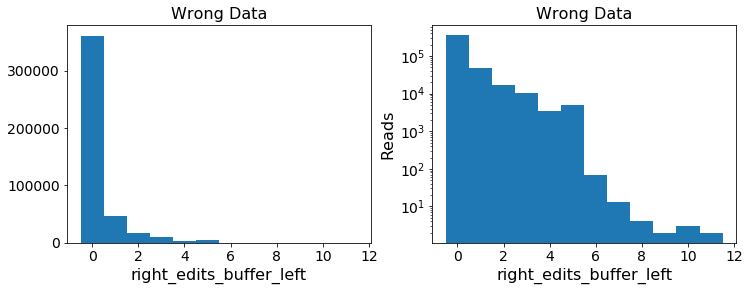

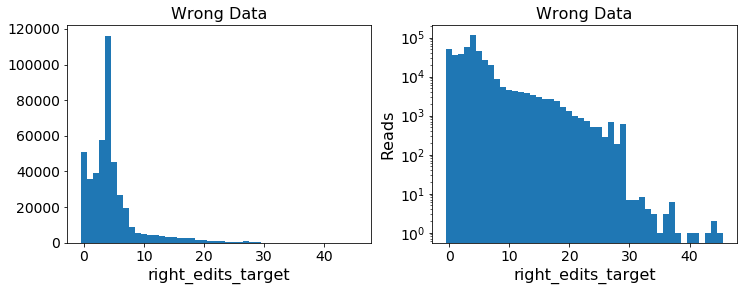

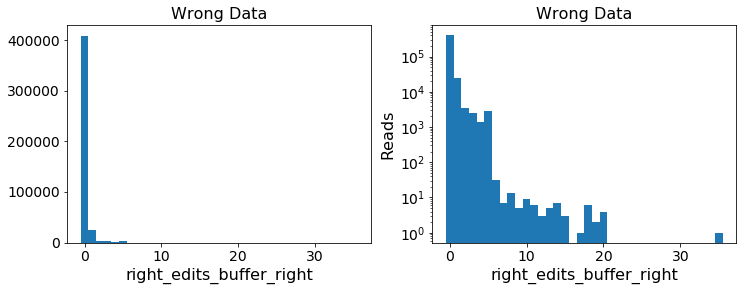

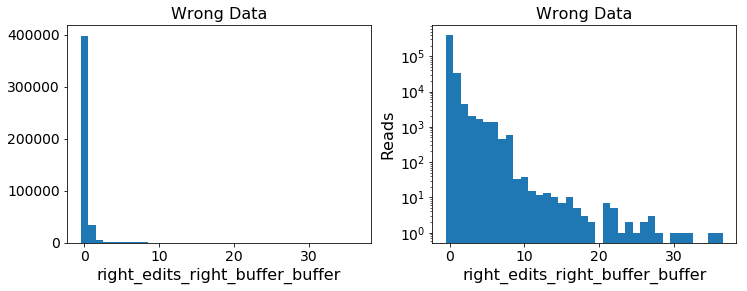

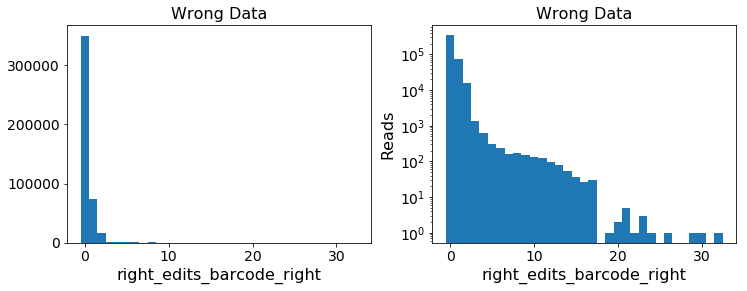

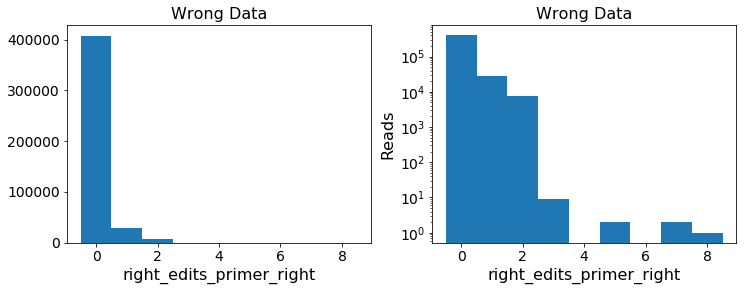

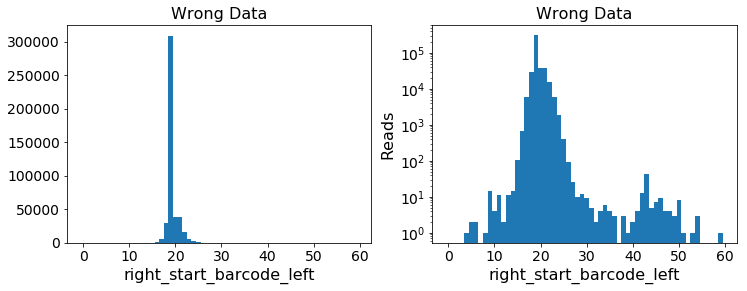

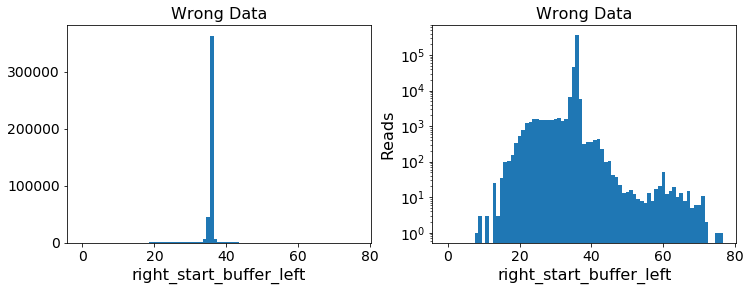

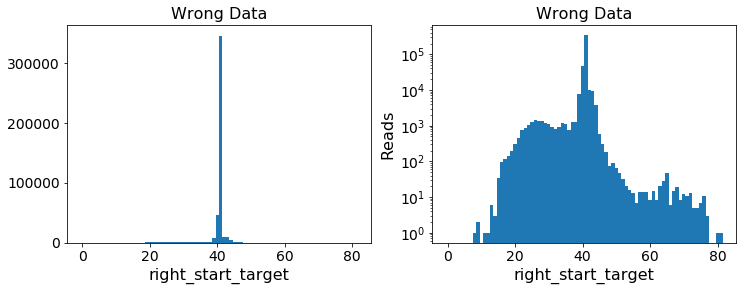

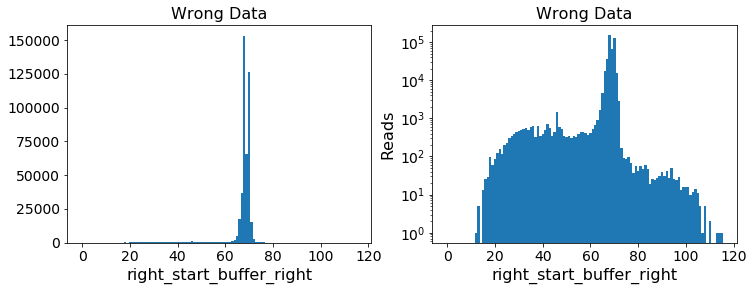

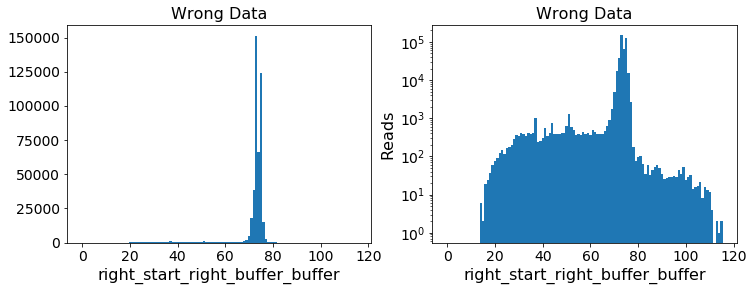

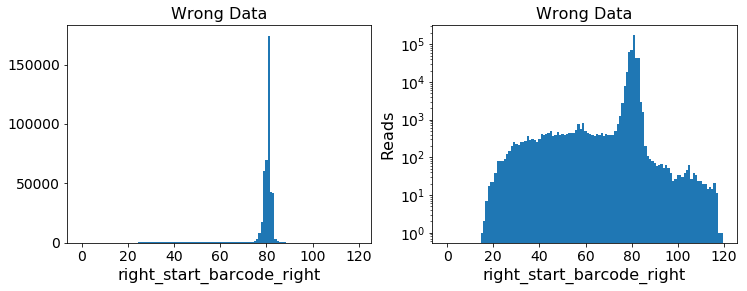

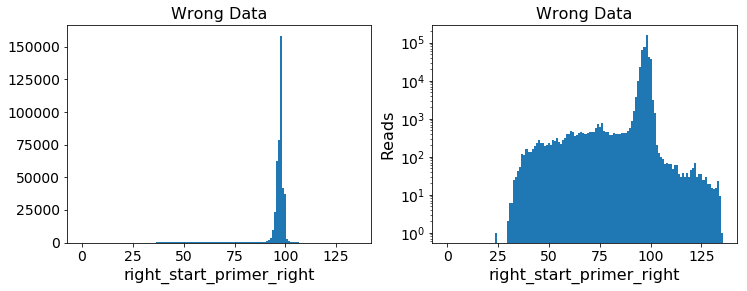

In [23]:
title = 'Wrong Data'
df = wrong_data
for label in df.columns:
    if label in ['read_name', 'sample', 'oriented_seq', 'oligo', 'left_oligo', 'right_oligo'] or 'aligned' in label:
        continue
    bins = np.arange(max(df[label]) + 2) - 0.5
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax = axes[0]
    ax.hist(df[label], bins)
    ax.set_xlabel(label)
    ax.set_title(title)
    ax = axes[1]
    ax.hist(df[label], bins)
    ax.set_yscale('log')
    ax.set_xlabel(label)
    ax.set_ylabel('Reads')
    ax.set_title(title)
    if label == 'seq_len':
        for ax in axes:
            ylim = ax.get_ylim()
            ax.plot([target_oligo_len]*2, ylim, ':', color='grey', zorder=-1)
            ax.set_ylim(ylim)

# By sample

We now look at the read counts for each of the above data classes by sample, i.e. time point. These are given for data filtered to have good length. The first figure shows absolute read count while the second shows each as the fraction of total reads for that sample. That is, each data type in the first figure divided by "Total". 

Also note that we break down the None and Wrong categories into left and right. These correspond to the left or right barcode being missing or wrong, respectively. Wrong barcodes are identified as those whose expected full oligo sequence is furthest from the observed.

In [24]:
read_names_given_sample = seqtools.load_read_names_given_sample(read_name_by_sample_fpath)

2020-04-12 05:57:42   Loading read_names_given_sample from JA18412-100827729/Cas9_D_read_names_by_sample.txt


Text(0,0.5,'Reads')

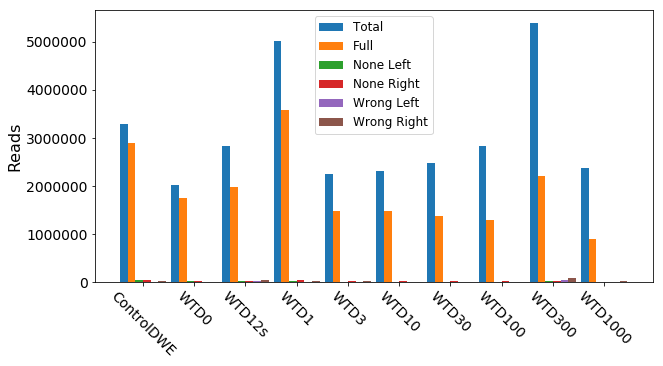

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

w = 0.15
idx = np.arange(len(sample_names))

y = [len(read_names_given_sample[sample]) for sample in sample_names]
ax.bar(idx - 2.5 * w, y, width=w, label='Total')

y = [sum(1 for s in good_len_data['sample'] if s == sample) for sample in sample_names]
ax.bar(idx - 1.5 * w, y, width=w, label='Full')

y = [sum(1 for s, missing in zip(good_len_none_data['sample'], good_len_none_data.missing_side) if s == sample and missing == 'left')
     for sample in sample_names]
ax.bar(idx - 0.5 * w, y, width=w, label='None Left')

y = [sum(1 for s, missing in zip(good_len_none_data['sample'], good_len_none_data.missing_side) if s == sample and missing == 'right')
     for sample in sample_names]
ax.bar(idx + 0.5 * w, y, width=w, label='None Right')

y = [sum(1 for s, left_edits, right_edits 
         in zip(good_len_wrong_data['sample'], good_len_wrong_data.left_total_edits, good_len_wrong_data.right_total_edits)
         if s == sample and left_edits >= right_edits)
     for sample in sample_names]
ax.bar(idx + 1.5 * w, y, width=w, label='Wrong Left')

y = [sum(1 for s, left_edits, right_edits 
         in zip(good_len_wrong_data['sample'], good_len_wrong_data.left_total_edits, good_len_wrong_data.right_total_edits)
         if s == sample and left_edits < right_edits)
     for sample in sample_names]
ax.bar(idx + 2.5 * w, y, width=w, label='Wrong Right')

ax.set_xticks(range(len(sample_names)))
ax.set_xticklabels(sample_names, rotation=-45)
#ax.set_ylim((0, 1e6))
ax.legend(fontsize=12)
ax.set_ylabel('Reads')

Text(0,0.5,'Fraction of Total')

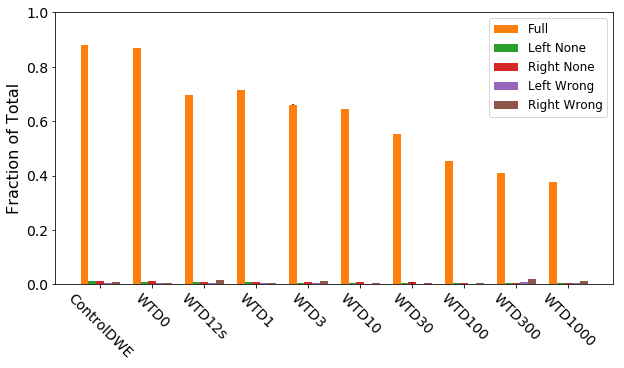

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

w = 0.15
idx = np.arange(len(sample_names))


total = np.array([len(read_names_given_sample[sample]) for sample in sample_names], dtype=np.float)
ax.bar([], [])

label_and_y = [
    ('Full', 
     [sum(1 for s in good_len_data['sample'] if s == sample) for sample in sample_names]),
    ('Left None', 
     [sum(1 for s, missing in zip(good_len_none_data['sample'], good_len_none_data.missing_side) 
          if s == sample and missing == 'left')
      for sample in sample_names]),
    ('Right None',
     [sum(1 for s, missing in zip(good_len_none_data['sample'], good_len_none_data.missing_side) 
          if s == sample and missing == 'right')
      for sample in sample_names]),
    ('Left Wrong',
     [sum(1 for s, left_edits, right_edits 
          in zip(good_len_wrong_data['sample'], good_len_wrong_data.left_total_edits, good_len_wrong_data.right_total_edits)
          if s == sample and left_edits >= right_edits)
      for sample in sample_names]),
    ('Right Wrong',
     [sum(1 for s, left_edits, right_edits 
          in zip(good_len_wrong_data['sample'], good_len_wrong_data.left_total_edits, good_len_wrong_data.right_total_edits)
          if s == sample and left_edits < right_edits)
      for sample in sample_names]),
]

for i, (label, y) in enumerate(label_and_y):
    y = np.array(y)
    yerr = 1.96 / total * np.sqrt(y * (total-y) / total)
    ax.bar(idx + (-2 + i)*w, np.array(y, dtype=np.float)/total, width=w, yerr=yerr, label=label, align='center')

ax.set_xticks(range(len(sample_names)))
ax.set_xticklabels(sample_names, rotation=-45)
ax.set_ylim((0, 1))
ax.legend(fontsize=12)
ax.set_ylabel('Fraction of Total')

# Tabulation and Normalization Factors

Finally, we collate, filter, normalize and tabulate the data. We collate the data into two categories of oligos: the target oligos and the negative control non-target oligos. We then filter the target oligos to only consider those which did not have sequence errors in the target sequence or the buffer sequence on either side. We then find the first normalization factors, which account for differing total read counts per sample. And finally, we tabulate to find counts of each oligo in each sample.

In [27]:
from scipy.stats import pearsonr

In [28]:
from scipy.stats import gaussian_kde

In [29]:
target_data = good_len_data[good_len_data.oligo.isin([oligo.sequence for oligo in oligo_container.target_oligos])]
non_target_data = good_len_data[good_len_data.oligo.isin([oligo.sequence for oligo in oligo_container.non_target_oligos])]

In [30]:
good_target_data = target_data[target_data.edits_target == 0]
good_target_data = good_target_data[good_target_data.edits_buffer_right == 0]
good_target_data = good_target_data[good_target_data.edits_buffer_left == 0]

In [31]:
print 'Reads of full_data, good_len_data, target_data, and good_target_data (no errors in or near target):'
len(full_data), len(good_len_data), len(target_data), len(good_target_data)

Reads of full_data, good_len_data, target_data, and good_target_data (no errors in or near target):


(19590594, 18908737, 18752874, 13384053)

In [32]:
print 'Non-target reads:', len(non_target_data)

Non-target reads: 155863


In [33]:
control_read_count = len(read_names_given_sample[sample_names[0]])
normalization_factors = [float(len(read_names_given_sample[sample]))/control_read_count
                         for sample in sample_names]

In [34]:
np.savetxt('{}_norm_factors.txt'.format(run_label), normalization_factors)
print 'Normalization factors:'
normalization_factors

Normalization factors:


[1.0,
 0.6148039908850382,
 0.8610403559546589,
 1.5256470152822008,
 0.6853101135352678,
 0.7007052316678877,
 0.7542092174092483,
 0.8606939947108386,
 1.6370097641608639,
 0.7212622888999743]

In [35]:
target_tab = pd.crosstab(good_target_data.oligo, good_target_data['sample'])
target_tab.to_pickle('{}_target_tab.pkl'.format(run_label))

In [36]:
nontarget_tab = pd.crosstab(non_target_data.oligo, non_target_data['sample'])
nontarget_tab.to_pickle('{}_nontarget_tab.pkl'.format(run_label))

In [37]:
print 'Target table summary:'
target_tab.describe()

Target table summary:


sample,ControlDWE,WTD0,WTD1,WTD10,WTD100,WTD1000,WTD12s,WTD3,WTD30,WTD300
count,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000
mean,243.104879,148.246494,299.034187,121.598911,101.991540,68.381272,163.170240,123.680496,109.676788,172.170124
std,144.113483,88.298221,238.333399,109.730648,110.263049,92.603388,126.965082,104.609929,106.510898,206.953879
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,141.000000,86.000000,111.000000,30.000000,15.000000,4.000000,65.000000,38.000000,21.000000,17.000000
50%,212.000000,128.000000,251.000000,97.000000,65.000000,16.000000,138.000000,102.000000,82.000000,80.000000
75%,314.000000,191.000000,419.000000,178.000000,155.000000,112.000000,227.000000,177.000000,164.000000,273.000000
max,1740.000000,965.000000,2277.000000,1074.000000,1114.000000,937.000000,1202.000000,1009.000000,1151.000000,2066.000000


In [38]:
print 'Non-target table summary:'
nontarget_tab.describe()

Non-target table summary:


sample,ControlDWE,WTD0,WTD1,WTD10,WTD100,WTD1000,WTD12s,WTD3,WTD30,WTD300
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,345.636364,194.090909,503.054545,248.381818,248.327273,204.672727,221.036364,201.218182,236.690909,430.763636
std,159.143583,87.533332,220.646140,113.690856,110.258460,97.620022,106.917407,94.284772,106.491327,198.185002
min,75.000000,42.000000,105.000000,46.000000,53.000000,37.000000,33.000000,31.000000,45.000000,66.000000
25%,202.500000,120.500000,304.500000,155.000000,150.500000,128.500000,133.000000,119.000000,145.500000,250.000000
50%,355.000000,195.000000,526.000000,260.000000,244.000000,201.000000,227.000000,206.000000,250.000000,456.000000
75%,443.000000,240.000000,634.000000,305.500000,321.000000,259.500000,277.000000,256.500000,302.000000,563.500000
max,703.000000,412.000000,972.000000,556.000000,504.000000,476.000000,557.000000,459.000000,506.000000,898.000000
